# Import all of the libraries and packages you'll need

In [1]:
import numpy
import scipy.stats # for calculating t-tests and other statistics
import netCDF4
import matplotlib.pyplot as mp
import matplotlib.cm as cm
import datetime as dt

mp.rcParams.update({'mathtext.default': 'regular'}) # use sans serif with Latex fonts

%matplotlib inline

In [2]:
#Hack to fix missing PROJ4 env var
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits import basemap

# List all available models

In [3]:
model_names = numpy.array(( \
['BCC-CSM2-MR',
 'CESM2',
 'GFDL-ESM4',
 'GISS-E2-1-G',
 'IPSL-CM6A-LR',
 'MIROC-E2SL',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0']))

* Input file path and names for models

In [4]:
file_root = '/home/datasets/aos112_2020/AOS112_Lab_1_Projection_monthly_data/cmip6/'

pr_hist = numpy.array(( \
['pr_Amon_BCC-CSM2-MR_hist_185001-201412_regrid.nc',
 'pr_Amon_CESM2_hist_185001-201412_regrid.nc',
 'pr_Amon_GFDL-ESM4_hist_185001-201412_regrid.nc',
 'pr_Amon_GISS-E2-1-G_hist_185001-201412_regrid.nc',
 'pr_Amon_IPSL-CM6A-LR_hist_185001-201412_regrid.nc',
 'pr_Amon_MIROC-E2SL_hist_185001-201412_regrid.nc',
 'pr_Amon_MPI-ESM1-2-LR_hist_185001-201412_regrid.nc',
 'pr_Amon_MRI-ESM2-0_hist_185001-201412_regrid.nc']))

* Extract lat and lon info from one of the model output

In [5]:
# example file to get lat/lon info
ncfile = netCDF4.Dataset(file_root+pr_hist[0], 'r', format='NETCDF4')
model_lat = ncfile.variables['lat'][:]
model_lon = ncfile.variables['lon'][:]

# Specify time periods and season
* Change season and months
* Re-open model data after change

In [6]:
hist_start = dt.datetime(1970,1,1)
hist_end = dt.datetime(2000,1,1)

season='DJF'; months=[12,1,2]
#season='MAM'; months=[3,4,5]
#season='JJA'; months=[6,7,8]
#season='SON'; months=[9,10,11]
#season='annual'; months=[1,2,3,4,5,6,7,8,9,10,11,12]

# Open observational estimate of precipitation
* NB: we are using the Global Precipitation Climatology Project (GPCP) monthly precipitation dataset that merges data from rain gauge stations, satellites, and sounding observations.
* These products can be affected by biases in the observational system, especially in places with few in-situ observations
* Climate modelers verify against multiple precipitation data sets, but for simplicity we are just using one product here

In [7]:
obs_file_root = '/home/datasets/aos112_2020/AOS112_Lab_1_Projection_monthly_data/observations/'
obs_file_name = 'gpcp_precip.mon.mean_invertlat.nc'
ncfile = netCDF4.Dataset(obs_file_root+obs_file_name, 'r', 'NetCDF4')
pr_obs_data = ncfile['precip']
time_variable = ncfile.variables['time']
date_start = netCDF4.date2num(hist_start, time_variable.units, time_variable.calendar)
date_end = netCDF4.date2num(hist_end, time_variable.units, time_variable.calendar)
time_variable_converted = netCDF4.num2date(time_variable[:], time_variable.units, time_variable.calendar)

time_indices = numpy.array([(t.month in months)&(t.year in range(hist_start.year, hist_end.year+1)) for t in time_variable_converted])
pr_obs_data_seas = pr_obs_data[time_indices,:,:]

# calculate time-mean (0-th axis=time)
pr_obs_clim = numpy.mean(pr_obs_data_seas, axis=0)

# Open model data for precipitation
* Open historical months for all models for season specified above
* Re-open model data after changing season
* This cell takes a while to complete

In [8]:
pr_hist_months_list = []

for i in range(model_names.size):
    
    print("opening model", model_names[i])

    # OPEN HISTORICAL PERIOD pr DATA
    modelname = model_names[i]
    ncfile = netCDF4.Dataset(file_root+pr_hist[i], 'r', format='NETCDF4')
    pr_hist_data = ncfile.variables['pr'][:,:,:]*86400. # convert from mm/sec to mm/day
    time_variable = ncfile.variables['time']
    date_start = netCDF4.date2num(hist_start, time_variable.units, time_variable.calendar)
    date_end = netCDF4.date2num(hist_end, time_variable.units, time_variable.calendar)
    model_time = time_variable[:]
    
    time_variable_converted = netCDF4.num2date(time_variable[:], time_variable.units, time_variable.calendar)
        
    time_indices = numpy.array([(t.month in months)&(t.year in range(hist_start.year, hist_end.year+1)) for t in time_variable_converted])
    pr_hist_data_seas = pr_hist_data[time_indices,:,:]
    
    # Add the data from the i-th model to the list
    pr_hist_months_list.append(pr_hist_data_seas[:,:,:])

opening model BCC-CSM2-MR
opening model CESM2
opening model GFDL-ESM4
opening model GISS-E2-1-G
opening model IPSL-CM6A-LR
opening model MIROC-E2SL
opening model MPI-ESM1-2-LR
opening model MRI-ESM2-0


# Notes

* All of the data are now collected in the list:
 * `pr_hist_months_list`
* This list has 8 entries in them, each of which is a 3D field (time x latitude x longitude), with the year and season corresponding to the values chosen in the __"Specify time periods and season"__ box above.

# Calculate climatologies for historical fields

In [9]:
# create empty lists to store the climatologies, anomalies, 
# and pvalues for a statistical significance test

pr_hist_clim_list = []

# calculate the fields listed above for each model, 
#  and "append" the results to the existing lists
# uncomment the print line below to see how the size of the lists change with i
for i in range(model_names.size):
    #print(pr_hist_months_list[i].shape, pr_rcp_months_list[i].shape)
    pr_hist_clim_list.append(numpy.mean(pr_hist_months_list[i], axis=0))

* Print the model index that corresponds to model names, so that you can specify which model to plot later
* The number next to the model name is its index

In [10]:
# print model name next to index
for i in range(model_names.size):
    print(i, model_names[i])

0 BCC-CSM2-MR
1 CESM2
2 GFDL-ESM4
3 GISS-E2-1-G
4 IPSL-CM6A-LR
5 MIROC-E2SL
6 MPI-ESM1-2-LR
7 MRI-ESM2-0


# Plot a model climatology field
* Choose the __`model_index`__ and plot
* Default: 2 GFDL-ESM4

In [11]:
model_index = 2

* Plot

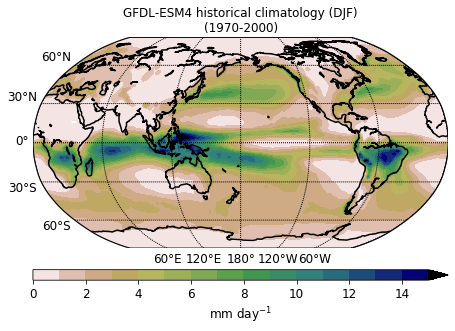

In [12]:
# 1. set up figure
fig = mp.figure(figsize=(7,4.5))
ax = fig.add_subplot(111)
map = basemap.Basemap(projection='robin', lon_0=-180., resolution='c')

# 2. draw coastlines, latitude and longitudes
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')
parallels = numpy.arange(-60.,61.,30.)
meridians = numpy.arange(0.,361.,60.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)

lons,lats = numpy.meshgrid(model_lon, model_lat)
xi,yi = map(lons, lats)

contour_levels = numpy.arange(0,16,1)
pr_map = map.contourf(xi,yi,pr_hist_clim_list[model_index],cmap='gist_earth_r', levels=contour_levels, extend='max')
cbar = map.colorbar(pr_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('mm day$^{-1}$', fontsize=12)

ax.set_title(model_names[model_index]+' historical climatology ('+season+')\n' + '('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=12)

mp.tight_layout()

# Plot model field and observations side-by-side
* By default keeps the same model as above (to change uncomment the __`model_index=`__ line and choose model)

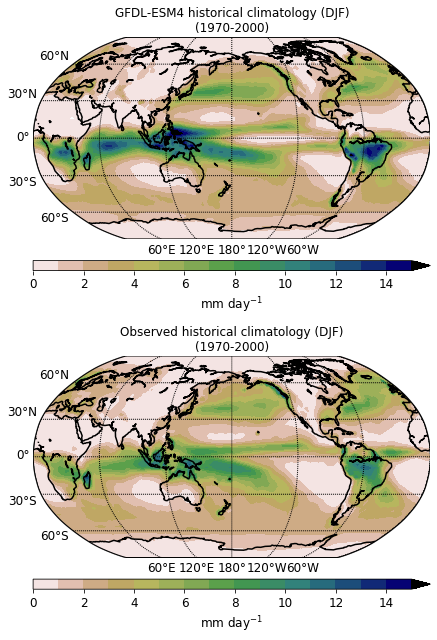

In [13]:
# model_index = 8

fig = mp.figure(figsize=(7,9))

ax1 = fig.add_subplot(211)
map = basemap.Basemap(projection='robin', lon_0=-180., resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')
parallels = numpy.arange(-60.,61.,30.)
meridians = numpy.arange(0.,361.,60.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)
lons,lats = numpy.meshgrid(model_lon, model_lat)
xi,yi = map(lons, lats)
contour_levels = numpy.arange(0,16,1)
pr_map = map.contourf(xi,yi,pr_hist_clim_list[model_index],cmap='gist_earth_r', levels=contour_levels, extend='max')
cbar = map.colorbar(pr_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('mm day$^{-1}$', fontsize=12)
ax1.set_title(model_names[model_index]+' historical climatology ('+season+')\n' + '('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=12)


ax2 = fig.add_subplot(212)
map = basemap.Basemap(projection='robin', lon_0=-180., resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')
parallels = numpy.arange(-60.,61.,30.)
meridians = numpy.arange(0.,361.,60.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)
lons,lats = numpy.meshgrid(model_lon, model_lat)
xi,yi = map(lons, lats)
contour_levels = numpy.arange(0,16,1)
pr_map = map.contourf(xi,yi,pr_obs_clim,cmap='gist_earth_r', levels=contour_levels, extend='max')
cbar = map.colorbar(pr_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('mm day$^{-1}$', fontsize=12)
ax2.set_title('Observed historical climatology ('+season+')\n' + '('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=12)

fig.tight_layout()
#mp.savefig('plots/pr_climatology_'+model_names[model_index]+'_'+season+'_and_observations.pdf', transparent=True, bbox_inches='tight')

# Model minus observations
* By default keeps the same model as above (to change uncomment the __`model_index=`__ line and choose model)

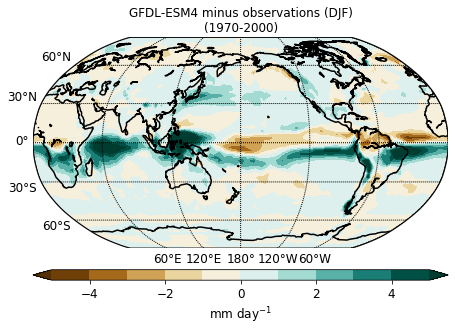

In [14]:
# model_index = 8

fig = mp.figure(figsize=(7,4.5))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='robin', lon_0=-180., resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')
parallels = numpy.arange(-60.,61.,30.)
meridians = numpy.arange(0.,361.,60.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)
lons,lats = numpy.meshgrid(model_lon, model_lat)
xi,yi = map(lons, lats)
contour_levels = numpy.arange(-5,5.1,1)
pr_map = map.contourf(xi,yi,pr_hist_clim_list[model_index]-pr_obs_clim,cmap='BrBG', levels=contour_levels, extend='both')
cbar = map.colorbar(pr_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('mm day$^{-1}$', fontsize=12)
ax.set_title(model_names[model_index]+' minus observations ('+season+')\n' + '('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=12)

fig.tight_layout()
#mp.savefig('plots/pr_climatology_'+model_names[model_index]+'_minus_observations_'+season+'.pdf', transparent=True, bbox_inches='tight')

# Multi-model ensemble mean (MMEM) minus observations
* Calculate MMEM

In [15]:
pr_hist_clim_mmem = numpy.mean(numpy.array(pr_hist_clim_list), axis=0)

* Plot MMEM minus Observation

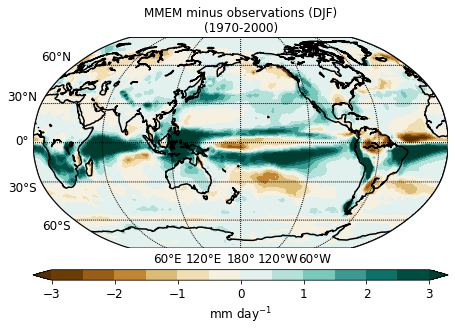

In [16]:
fig = mp.figure(figsize=(7,4.5))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='robin', lon_0=-180., resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')
parallels = numpy.arange(-60.,61.,30.)
meridians = numpy.arange(0.,361.,60.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)
lons,lats = numpy.meshgrid(model_lon, model_lat)
xi,yi = map(lons, lats)
contour_levels = numpy.arange(-3,3.1,0.5)
pr_map = map.contourf(xi,yi,pr_hist_clim_mmem-pr_obs_clim,cmap='BrBG', levels=contour_levels, extend='both')
cbar = map.colorbar(pr_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('mm day$^{-1}$', fontsize=12)
ax.set_title('MMEM minus observations ('+season+')\n' + '('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=12)

fig.tight_layout()
#mp.savefig('plots/pr_climatology_MMEM_minus_observations_'+season+'.pdf', transparent=True, bbox_inches='tight')

### WARNING:  The code in the box below plots a 6x6 panel of all models.  This is a slow process so the cell has been commented out (cell type changed to not execute).

* To run it, select the box and in the drag-down menu above, and instead of __Raw__ choose __Code__, then run the Cell

* Plot all 36 model plots in a panel (WARNING: this is a slow process)